In [1]:
# Import dependencies
import json
import pandas as pd
import numpy as np
import re

In [2]:
# Create path for data resources
file_dir = "../Movies-ETL/data"

In [3]:
# Read raw JSON data file into pandas
with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)

In [4]:
# Read raw Kaggle data into pandas
kaggle_metadata = pd.read_csv(f'{file_dir}/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}/ratings.csv')

In [5]:
# Trim down initial JSON movie list to clean data
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]
wiki_movies_df = pd.DataFrame(wiki_movies)

In [6]:
# Define function to clean individual movies in list
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    # combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune-Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')

    return movie

In [7]:
# Make a list of cleaned movies
clean_movies = [clean_movie(movie) for movie in wiki_movies]
# Create a DataFrame from the clean_movies list
wiki_movies_df = pd.DataFrame(clean_movies)

In [8]:
sorted(wiki_movies_df.columns.tolist())

['Animation by',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Created by',
 'Director',
 'Distributor',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'Genre',
 'Label',
 'Language',
 'McCune–Reischauer',
 'Narrated by',
 'Original language(s)',
 'Original network',
 'Picture format',
 'Preceded by',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Recorded',
 'Release date',
 'Running time',
 'Starring',
 'Suggested by',
 'Venue',
 'Voices of',
 'Writer(s)',
 'alt_titles',
 'imdb_link',
 'title',
 'url',
 'year']

In [9]:
# Extract the IMDB ID tag from each row
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
# Check length of DataFrame
print(len(wiki_movies_df))
# Drop duplicate rows from the DataFrame that contain the same IMDB ID 
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
# Check length of DataFrame
print(len(wiki_movies_df))

7076
7033


In [10]:
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [11]:
# Check length of DataFrame
print(len(wiki_movies_df))
# Drop duplicate rows from the DataFrame that contain the same IMDB ID 
box_office = wiki_movies_df['Box office'].dropna()
budget = wiki_movies_df['Budget'].dropna()
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
# Check length of DataFrame
# print(len(box_office))
# print(len(budget))
# print(len(release_date))
print(len(running_time))

7033
6894


In [12]:
# Create a function to clean up [Box office] and [Budget] data
box_office = box_office.map(lambda x: ' '.join(x) if type(x) == list else x)
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
# Remove range designations, such has hyphens
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [13]:
# Create regex string forms to capture monetary amounts
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+'
# Create regex string forms to capture date information
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'
# box_office.str.contains(form_one, flags=re.IGNORECASE, na=False).sum()
# budget.str.contains(form_one, flags=re.IGNORECASE, na=False).sum()
running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False).sum()

6877

In [14]:
# box_office.str.contains(form_two, flags=re.IGNORECASE, na=False).sum()
# budget.str.contains(form_two, flags=re.IGNORECASE, na=False).sum()

In [15]:
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE, na=False)
# box_office[~matches_form_one & ~matches_form_two]
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
budget = budget.str.replace(r'\[\d+\]\s*', '')
# budget[~matches_form_one & ~matches_form_two]

C:\Users\culle\AppData\Local\Temp\ipykernel_25404\266639334.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  budget = budget.str.replace(r'\[\d+\]\s*', '')


In [16]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [17]:
# Create new box office and budget columns to contain usable data types using the parsing function
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)
# Extract running time from the various strings in run time column
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
# Convert run time extracted strings to numerical values
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
# Create new running time column based on extracted numerical values and fill null values
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
# Drop old columns from data frame that have been replaced with clean columns
wiki_movies_df.drop('Box office', axis=1, inplace=True)
wiki_movies_df.drop('Budget', axis=1, inplace=True)
wiki_movies_df.drop('Release date', axis=1, inplace=True)
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [18]:
wiki_movies_df.dtypes

url                              object
year                              int64
imdb_link                        object
title                            object
Based on                         object
Starring                         object
Cinematography                   object
Country                          object
Language                         object
Director                         object
Distributor                      object
Editor(s)                        object
Composer(s)                      object
Producer(s)                      object
Production company(s)            object
Writer(s)                        object
imdb_id                          object
box_office                      float64
budget                          float64
release_date             datetime64[ns]
running_time                    float64
dtype: object

In [19]:
wiki_movies_df.sample(5)

,url,year,imdb_link,title,Based on,Starring,Cinematography,Country,Language,Director,...,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget,release_date,running_time
4206,https://en.wikipedia.org/wiki/Pulse_(2006_film),2006,https://www.imdb.com/title/tt0454919/,Pulse,"[Pulse, by Kiyoshi Kurosawa]","[Kristen Bell, Ian Somerhalder, Christina Mili...",Mark Plummer,United States,English,Jim Sonzero,...,"[Bob Mori, Robert K. Lambert, Kirk M. Morri]",Elia Cmiral,"[Anant Singh, Brian Cox, Michael Leahy, Joel S...",Distant Horizon,"[Wes Craven, Ray Wright]",tt0454919,30000000.0,20500000.0,2006-08-11,88.0
4096,https://en.wikipedia.org/wiki/Hood_of_Horror,2006,https://www.imdb.com/title/tt0475298/,Hood of Horror,NaN,"[Snoop Dogg, Ernie Hudson, Danny Trejo, Anson ...",Claudio Rocha,United States,English,Stacy Title,...,"[Luis Colina, Jason Resmer]",Snoop Dogg,"[Jonathan McHugh, Martin Shore, Christopher Tu...","[Social Capital Films, BloodWorks, Snoopadelic...","[Jacob Hair, Chris Kobin, Jonathan McHugh, Tim...",tt0475298,25900.0,5000000.0,2006-06-27,88.0
5437,https://en.wikipedia.org/wiki/28_Hotel_Rooms,2012,https://www.imdb.com/title/tt2124074/,28 Hotel Rooms,NaN,"[Chris Messina, Marin Ireland]",Doug Emmett,United States,English,Matt Ross,...,Joseph Krings,NaN,"[Lynette Howell, Louise Runge, Samantha Housman]","[Mott Street Pictures, OneZero Productions, Si...",Matt Ross,tt2124074,18869.0,NaN,2012-11-09,82.0
5204,https://en.wikipedia.org/wiki/Stone_(2010_film),2010,https://www.imdb.com/title/tt1423995/,Stone,NaN,"[Robert De Niro, Edward Norton, Milla Jovovich...",Maryse Alberti,United States,English,John Curran,...,Alexandre de Franceschi,Cliff Eidelman,"[Holly Wiersma, David Mimran, Jordan Schur]",Mimran Schur Pictures,Angus MacLachlan,tt1423995,9479718.0,22000000.0,2010-09-10,105.0
4364,https://en.wikipedia.org/wiki/The_Comebacks,2007,https://www.imdb.com/title/tt0790804/,The Comebacks,NaN,"[David Koechner, Carl Weathers, Melora Hardin,...",Anthony B. Richmond,United States,English,Tom Brady,...,Alan Edward Bell,Christopher Lennertz,"[Adam F. Goldberg, Robert L. Levy, Andrew Pana...",Tapestry Films,"[John Aboud, Michael Colton, Adam Jay Epstein,...",tt0790804,13539154.0,20000000.0,2007-10-19,84.0


In [20]:
# Clean up the kaggle dataset
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [21]:
# Clean the ratings dataset
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

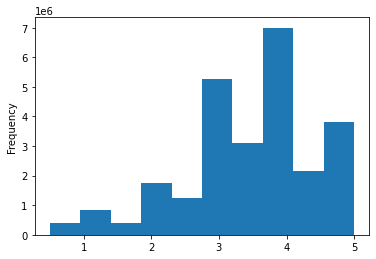

In [22]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()

In [23]:
# Create a merged DataFrame out of wiki and kaggle cleaned datasets
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])
# Drop invalid rows from merged DataFrame
movies_df = movies_df.drop(movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index)
# Convert language values to tuples for analysis
# movies_df['Language'].apply(lambda x: tuple(x) if type(x) == list else x).value_counts(dropna=False)
# movies_df['original_language'].value_counts(dropna=False)

In [24]:
# Competing data:
# Wiki                     Movielens                Resolution
#--------------------------------------------------------------------------
# title_wiki               title_kaggle             Drop Wikipedia
# running_time             runtime                  Keep Kaggle; fill in zeros with Wikipedia data.
# budget_wiki              budget_kaggle            Keep Kaggle; fill in zeros with Wikipedia data.
# box_office               revenue                  Keep Kaggle; fill in zeros with Wikipedia data.
# release_date_wiki        release_date_kaggle      Drop Wikipedia.
# Language                 original_language        Drop Wikipedia.
# Production company(s)    production_companies     Drop Wikipedia.
# Drop column data based on the above action plan
movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)

In [25]:
# Create function to fill missing kaggle data with data from wiki
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
        , axis=1)
    df.drop(columns=wiki_column, inplace=True)

In [26]:
# Clean merged DataFrame based on aforementioned action plan
fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')

In [27]:
for col in movies_df.columns:
    lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
    value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
    num_values = len(value_counts)
    if num_values == 1:
        print(col)

video


In [28]:
movies_df['video'].value_counts(dropna=False)

False    6051
Name: video, dtype: int64

In [29]:
# Organize merged DataFrame
movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries','Distributor',
                       'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
                      ]]

In [30]:
# Fix names in merged DataFrame
movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

In [31]:
# Summarize the ratings dataset and pivot the data for efficiency
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')
rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]

In [32]:
# Merge the pivoted summary ratings DataFrame to the movies_df
movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')
# Fill null values from the ratings merge
movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)

In [33]:
movies_df.sample(5)

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,production_countries,distributor,producers,director,starring,cinematography,editors,writers,composers,based_on
890,tt0110632,241,Natural Born Killers,Natural Born Killers,The Media Made Them Superstars.,NaN,https://en.wikipedia.org/wiki/Natural_Born_Kil...,https://www.imdb.com/title/tt0110632/,119.00,"34,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Warner Bros.,"[Jane Hamsher, Don Murphy, Clayton Townsend]",Oliver Stone,"[Woody Harrelson, Juliette Lewis, Robert Downe...",Robert Richardson,"[Hank Corwin, Brian Berdan]",Quentin Tarantino,NaN,NaN
1555,tt0125678,14887,Bongwater,Bongwater,When everything in life goes to pot.,NaN,https://en.wikipedia.org/wiki/Bongwater_(film),https://www.imdb.com/title/tt0125678/,97.00,"1,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",First Look International,"[Laura Bickford, Alessandro F. Uzielli]",Richard Sears,"[Luke Wilson, Alicia Witt, Jack Black, Brittan...",Richard Crudo,Lauren Zuckerman,"[Nora Maccoby, Eric Weiss]","[Josh Mancell, Mark Mothersbaugh]","[Bongwater, by, Michael Hornburg]"
1498,tt0117995,75471,Twisted Desire,Twisted Desire,Nothing can come between a girl and her true l...,NaN,https://en.wikipedia.org/wiki/Twisted_Desire,https://www.imdb.com/title/tt0117995/,96.00,NaN,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NBC,Judy Cairo,Craig R. Baxley,"[Melissa Joan Hart, Daniel Baldwin, Jeremy Jor...",João Fernandes,Sonny Baskin,"[Carey Hayes, Chad Hayes]",Gary Chang,NaN
5484,tt2828996,184345,A Haunted House 2,A Haunted House 2,It'll scare the #2 out of you.,"{'id': 251937, 'name': 'A Haunted House Collec...",https://en.wikipedia.org/wiki/A_Haunted_House_2,https://www.imdb.com/title/tt2828996/,87.00,"4,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Open Road Films,"[Marlon Wayans, Rick Alvarez]",Michael Tiddes,"[Marlon Wayans, Jaime Pressly, Essence Atkins,...",David Ortkiese,Tim Mirkovich,"[Marlon Wayans, Rick Alvarez]",Jesse Voccia,"[Characters, by Marlon Wayans, Rick Alvarez]"
5451,tt1878942,99367,Date and Switch,Date and Switch,Love's all about finding the right combination.,NaN,https://en.wikipedia.org/wiki/Date_and_Switch,https://www.imdb.com/title/tt1878942/,91.00,"6,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Lionsgate,"[Jai Stefan, Laurence Mark, David Blackman]",Chris Nelson,"[Nicholas Braun, Hunter Cope, Dakota Johnson, ...",David Robert Jones,"[Tia Nolan, Akiko Iwakawa-Grieve]",Alan Yang,Eric D. Johnson,NaN
